#  <span style="color:darkred">Data extraction and visualization</span>
The below scripts are made by Henriette Steenhoff, s134869, to help visualize the sampling of different indoor climate measures for the master thesis of Anne Sloth Bidstrup, s112862 at The Technical University of Denmark (DTU) anno 2017.

----

##  <span style="color:darkred">Information about the different data sources</span>
### Structure data in weekly batches
* Processed data for each week (all time)
 * Such that it can be used for all time analysis
* Processed data hourly (maybe)
* Different diagrams/plots/visualizations
*

#### For hver bolig
* State number of rooms and names

### De forskellige datakilder
* CO2 + varme + fugtighed fra netatmo - kun 3 rum, 3 forksellige ark
 * Luftfugtighed - for hvert rum - brug al data, lav inddeling som i feedback brev
 * CO2 -- vigtig ifm. ``PIR`` og ``reed``- for stue/køkken og soveværelse
* Temp fra Bygweb - sorteres fra

### Different measures, what to use
``Pir`` and ``reed`` -- merge tables!

#### ``PIR`` - bevægelsescensor
* Det spændende, tegn på hjemme hvis mellem ``close`` og ``open``
* ``Timed out`` - no more move, **kan sorteres fra**

#### ``Reed`` - dør
* Present/home values ``open/close``

#### ``Compas/Acc`` - moved, mangler lidt på 
* ONLY ``moved``
* Sorted by room
* *Number of entities*
* % of time one has been at home

Heat consumption - average

``Hedelyngen`` - avg of all homes - kommer et andet sted fra

----
### Documentation
Some references for help on different coding solutions

* [Panda Docs](http://pandaproject.net/docs/importing-access-files.html)
* [Plotly Docs](https://plot.ly/python/ipython-notebook-tutorial/)

### To-do:
- Look into possibilities for making transparent background on plots to save $\checkmark$ - *given as argument in plot* [see here](http://stackoverflow.com/questions/29968152/python-setting-background-color-to-transparent-in-plotly-plots)
- Find target group in need of feedback $\checkmark$ - Anne has list
- Separate processed datasets from raw data (in folders) $\checkmark$ - done ultimo March
- Make system to distinguish between weeks and different users $\checkmark$ - *weekly folders, alias and room identifiers*

----

## <span style="color:darkred">Explanation of how to run the code</span>

This section will give a brief introduction on how to
 * name the different files to be read
 * structure the raw data in order to be loaded into the program
 * find the different plots and output files
 
### I/O description
All input files must be put in the root of the directory. As this is done, the files used the week before (if any) needs to be moved to the weekly folder associated with the data. I.e. data from week 10 is still in root directory, move this to the folder ``Week_10`` - otherwise the data will not be read correctly.

#### Folder structure
This information is used for organizing files into right folders in the working directory.

* For each week there will be a folder named ``Week_x``, where ``x`` denotes the week. 
 * In the weekly folder there are two subfolders: ``Visualizations`` and ``ProcessedData``.
   * ``Visualizations`` contains bar charts, pie chart and plots for each week generated with the code below. Each home is uniquely identified by it's ``ID``.
   * ``ProcessedData`` contains all data used in that week sorted into files for each room in the house, this is the data extracted below. The different homes can be identified by the aliases made by Anne and a room identifier $\{stue, værelse\}$ etc. 

Since the data from Netatmo and Wireless will be interdependent, there will be no separate folder for the data sources. *Some data (unused fields and observations) has been removed to improve performance.*

#### Naming convention
#### Data files
Can all be found on dropbox in weekly folders in '``Program - filudtræk og arbejde``' in folder '``ProcessedData``' and subfolder '``AccCompas``' or '``PIRReed``'. There will be one file for each room.

**PIR/Reed**

Name: '``alias``-**PIRReed**``_room``.xlsx'

i.e ``he117-PIRReed_livingroom.xlsx``

**AccCompas**

Name: '``alias``-**AccCompas**``_room``.xlsx'

i.e ``he117-AccCompas_kitchen.xlsx``
#### PLOTS
All the visualizations are found in folder ``ProcessedData`` in subfolder ``Visualizations``. Filenames will start with the ``alias`` for the home at hand and be followed by an indication of which output we have $\{temp, co2, AccCompas, HR\}$ and what room the measurements belong to: $\{stue, værelse, entrance\}$.


**CO2 plot** 

Name: '``alias``-**co2**-``room``.png'

**Temperature plot** 

Name: '``alias``-**temp**-``room``.png'

**Movement** 

Name: '``alias``-**AccCompas**-``room``.png'

**Humidity rate** 

Name: '``alias``-**HR**-``room``.png'


### Running the code
<span style="color:darkred">Description will be added shortly</span>

----
## <span style="color:darkred">Data Preprocessing</span>

In [248]:
# Imports - getting relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import urllib2
from collections import Counter 
import numpy as np
from operator import itemgetter
from scipy import linalg
from os import *
from os.path import isfile, join
import time
from datetime import date, timedelta
import datetime
from pylab import *

import plotly 
from IPython.display import Image
plotly.tools.set_credentials_file(username='frksteenhoff2', api_key='duu8hsfRmuI5rF2EU8o5')
import plotly.plotly as py
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.graph_objs as go
import re
from fractions import Fraction

### Extracting basic information for the data

**Get currect week of year ($weekOfYear - 1$)**

In [3]:
# Minus one to indicate work on last week's data
weekNumber = date.today().isocalendar()[1]-1
print 'Week number:', weekNumber

Week number: 13


**Create new week folder in directory**

In [282]:
# Adding new folder Week_'x' to directory 
dir_name = "Week_"+str(weekNumber)
if not path.exists(dir_name):
    makedirs(dir_name)
    print "A new folder named '%s' have been created for data from week %d." % (dir_name, weekNumber)
else:
    print "An existing folder named '%s' was used" % dir_name

An existing folder named 'Week_13' was used


#### Methods for saving files correctly
This function is used when saving files to a certain directory. It is used when the data has been processed such that only the needed data is left. This is being done when merging **Acc/Compas** and **PIR/Reed**. 

In [283]:
def saveDataToFile(dir_, alias, string, df, dfcol, pattern): # string: concatenation of: censortype, room and file format (xlsx)
    # Taking care of aaaaall the different spellings of the rooms... adding to different files
    temp = df.loc[df[dfcol].str.contains(pattern)]
    
    # Only save file if it actually contains something
    if not temp.empty:
        full_path_filename = (dir_+alias+string).strip(' ') 
        writer = pd.ExcelWriter(full_path_filename, engine='xlsxwriter')
        print "Saving values for '%s', in all: %d" % (alias, len(temp))
        temp.to_excel(writer)
        writer.save()        

#### Patterns - taking care of different spellings and naming conventions for the rooms

*Can be optimised but is not a priority right now*

In [284]:
# LISTS OF DIFFERENT NAMES GIVEN FOR EACH ROOM.....
# Entrance
entre_pattern = '|'.join(['Entre PIR', 'EntrÃ© PIR', 'upstairs', 
                          'entrance/kitchen', 'hallway', 'PIR entrance',
                          'entrance','PIR gang', 'PIR stairs',
                          'Reed main enterance', 'reed main enterance',
                          'Reed main entrance', 'PIR Entre', 'Reed Main door',
                          'PIR trapper', 'Pir stairs', 'main entrance reed north',
                          'pir entrance', 'pir stairs', 'main enterance', 'Reed entrance', 'Main door Reed',
                          'entrance', 'entre', 'main entrance reed', 'Reed'])
# Living room
livingroom_pattern = '|'.join(['Stue PIR', 'PIR stue', 'PIR livingroom','PIR upstairs office/livingroom',
                               'PIR 1st floor living room', 'PIR uostairs living room', 
                               'living room', 'livingroom', 'stue', 'Stue',
                               'kitchen south', 'kitchen', 'kitchen South', 'livingroom/bedroom/kitchen', 'kken'])

bedroom_pattern = '|'.join(['Bedroom', 'bedroom', 'bed room', 'sove', 'Sove', 'uptairs'])

----
## <span style="color:darkred">Wireless work</span>

### Merge ``PIR`` and ``Reed``

In [285]:
# TABLE WITH ALL HOMES (for current week)
# Initialize dataframe
pir_reed_merge = pd.DataFrame()
fileNames = ['PIR', 'Reed']

# Read in files for PIR and Reed and merge to one 
for name in fileNames:
    data = pd.read_excel(name+".xlsx", name)
    pir_reed_merge = pir_reed_merge.append(data)

In [286]:
#pir_reed_merge

#### Remove all codes with values ``tempUpdate, TimeOut, ReEstablishedLink`` and ``LostLink``

In [287]:
# Remove unwanted temperature measuresold_obs = len(pir_reed_merge)
old_obs = len(pir_reed_merge)
pir_reed_merge = pir_reed_merge.loc[pir_reed_merge['code'].isin(['movement','open','closed'])]

# Remove unnecessary features (duration, lastContact, threshold, batVoltage, ID, time)
pir_reed_merge.drop(['duration','lastContact','threshold','battVoltage','ID','time_', 'rh', 'temp'], axis=1)

new_obs = len(pir_reed_merge)
print "Number of observations (temperature included):", old_obs
print "Number of observations (temperature excluded):", new_obs

Number of observations (temperature included): 27895
Number of observations (temperature excluded): 16213


### Saving Wireless data to files

The different naming conventions are handled by the different patterns in the preprocessing section.

Be advised! Due to lacking consistency in naming convention **some devices may not be included here**. Please make sure that running the code in section *Merging files containing same type of information* include the same room names as the ones  commented out below. -- otherwise contact Henriette.

#### Create individual files for each home
Containing merged PIR/Reed samples sorted by timestamp

In [288]:
# Clock time spent on execution
start_time = time.time()

# Produces the path Weekx/ProcessedData/Hexxx-'room'.xlsx
directory = dir_name + "/ProcessedData/PIRReed/"

# If directory path does not exist - create it
if not path.exists(directory):
    makedirs(directory)

# Merge correct files based on content type
for alias in list(set(pir_reed_merge['bolig'])):
    # Get data for specific home
    current_home = (pir_reed_merge.loc[pir_reed_merge['bolig'].isin([alias])]).sort_values(by=['submitDate','submitTime'])

    # Entrance
    saveDataToFile(directory, alias, "-PIRReed_entrance.xlsx", current_home, 'tagName', entre_pattern)
    # Living room
    saveDataToFile(directory, alias, "-PIRReed_livingroom.xlsx", current_home, 'tagName', livingroom_pattern)

    


#    not all have both pir + reed?
#    # nothing on bedroom?
#    # Bathroom - NOT NEEDED??
#    saveDataToFile(directory, alias, "-PIRReed_bathroom.xlsx", current_home, 'tagName', missing_pattern)
print("\n--- Execution time: %s seconds ---" % (time.time() - start_time))

Saving values for 'Ho46', in all: 94
Saving values for 'He145', in all: 46
Saving values for 'Aalbrovej21He59', in all: 156
Saving values for 'He183', in all: 149
Saving values for 'He99', in all: 14
Saving values for 'Ho48', in all: 114
Saving values for 'He107', in all: 284
Saving values for 'He107', in all: 78
Saving values for 'ho24', in all: 140
Saving values for 'ho24', in all: 80
Saving values for 'He104', in all: 146
Saving values for 'He87', in all: 180
Saving values for 'he147', in all: 71
Saving values for 'Ho92', in all: 90
Saving values for 'he143', in all: 153
Saving values for 'he141', in all: 133
Saving values for 'he103', in all: 70
Saving values for 'he103', in all: 47
Saving values for 'He197', in all: 76
Saving values for 'He197', in all: 176
Saving values for 'He61', in all: 412
Saving values for 'He61', in all: 98
Saving values for 'he109', in all: 73
Saving values for 'he109', in all: 38
Saving values for 'He27', in all: 60
Saving values for 'He27', in all: 40
Sa

In [289]:
#current_home.submitTime = pd.to_datetime(current_home.submitTime)
time_home = datetime.timedelta()
closedLast = False;

# find time home a day per home
for row in range(0,len(current_home)):
    if current_home.iloc[row,3] == 'closed' and not closedLast: # we only look at movement between door closes and door open again
        close_row = row
        closedLast = True
    elif current_home.iloc[row,3] == 'open' and closedLast:
        open_row = row
        time_elapsed = pd.to_datetime(current_home.iloc[open_row,9], format='%H:%M:%S') - pd.to_datetime(current_home.iloc[close_row,9], format='%H:%M:%S')
        time_home += time_elapsed
        closedLast = False
    elif row == len(current_home)-1:
        open_row = row
        time_elapsed = pd.to_datetime(current_home.iloc[open_row,9], format='%H:%M:%S') - pd.to_datetime(current_home.iloc[close_row,9], format='%H:%M:%S')
        time_home += time_elapsed
    else:
        print 'nothing'
        # TODO: take care of values when start !open and !close
        

nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing


In [290]:
#home_data
timeHomeOfDay = time_home
timeHomeOfDay

Timedelta('0 days 13:42:38')

### Get days in week

In [291]:
dates = []
# ----- Update for each week! ------- #
d1 = date(2017, 2, 20)  # start date
d2 = date(2017, 2, 26)  # end date

delta = d2 - d1         # timedelta

for i in range(delta.days + 1):
    dates.append(d1 + timedelta(days=i))

#### Extract number of movements (open/close of window) per week day

In [292]:
listMovements = []

for date in dates:
    day_movement = current_home.loc[current_home['submitDate'].isin([date])]
    noOfMovements = len(day_movement.loc[day_movement['code'].isin(['movement'])])
    listMovements.append(noOfMovements)
print listMovements

[0, 0, 27, 32, 25, 19, 33]


In [163]:
#dates
len(current_home.loc[current_home['submitDate'].isin(['2017-02-22'])])

32

### Getting number of times door has been opened per room ``while`` movement indoor
Homes can be extracted from folder ``PIRReed``, open/close per days is not interesting it is the overall weekly picture that is taken into account.

#### Find all files with certain extension (something with "door" in data directory for processed data)

In [23]:
# Clock time spent on execution
start_time = time.time()

# Initialize dataframe
acc_compas_merge = pd.DataFrame()
fileNames = ['Compas', 'Acc']
directory = dir_name + "/ProcessedData/AccCompas/"

# If directory path does not exist - create it
if not path.exists(directory):
    makedirs(directory)

# Read in files for Compas / Acc merge to one 
for name in fileNames:
    # Only read in needed columns
    data = pd.read_excel(name+".xlsx", name)# usecols=['tagName','tagID','code','bolig','temp','rh','submitDate','submitTime'])
    acc_compas_merge = acc_compas_merge.append(data)

# Count initial number of observations
#old_obs = len(acc_compas_merge)
#print old_obs

# Keep only code value 'moved'
acc_compas = acc_compas_merge.loc[acc_compas_merge['code'].isin(['moved'])]
# Removed unused columns (for a smaller file size to save)
acc_compas = acc_compas.drop(['temp','lastContact','threshold','battVoltage','ID','rh'], axis=1)

print "Number of observations (temperature included):", old_obs
print "Number of observations (temperature excluded):", len(acc_compas), "\n"

# Sort values from each room into separate files
for alias in list(set(acc_compas['bolig'])):
    # Get data for specific home
    current_home = (acc_compas.loc[acc_compas['bolig'].isin([alias])]).sort_values(by=['submitDate','submitTime'])
    # save bedroom info to file     #wayprettiercode (dir_, alias, string, df, dfcol, pattern)
    saveDataToFile(directory, alias, "-AccCompas_bedroom.xlsx", current_home, 'tagName', livingroom_pattern)
    # Save kitchen info to file
    saveDataToFile(directory, alias, "-AccCompas_kitchen.xlsx", current_home, 'tagName', kitchen_pattern)

print("\n--- Execution time: %s seconds ---" % (time.time() - start_time))

Number of observations (temperature included): 27895
Number of observations (temperature excluded): 2088
Saving values for 'Ho46', in all: 6
Saving values for 'Ho46', in all: 10
Saving values for 'He145', in all: 106
Saving values for 'He183', in all: 1
Saving values for 'Ho48', in all: 7
Saving values for 'He107', in all: 18
Saving values for 'He107', in all: 10
Saving values for 'He104', in all: 4
Saving values for 'ho48', in all: 4
Saving values for 'He87', in all: 10
Saving values for 'Ho92', in all: 1
Saving values for 'he143', in all: 5
Saving values for 'he143', in all: 6
Saving values for 'he103', in all: 18
Saving values for 'He197', in all: 4
Saving values for 'He61', in all: 7
Saving values for 'he109', in all: 3
Saving values for 'He27', in all: 13
Saving values for 'He69', in all: 21
Saving values for 'He221', in all: 2
Saving values for 'he9', in all: 3
Saving values for 'ho98', in all: 36
Saving values for 'he61', in all: 2
Saving values for 'he61', in all: 4
Saving valu

#### Merging moved data with PIR/Reed?

### Getting data for pie charts

* [Pie chart Docs](https://plot.ly/python/pie-charts/)

#### Plotting variables

In [245]:
# Setting the colors for the different plots, 
# such that all plots get the same colors
homeGreen = 'rgb(0, 204, 0)'
hedeBlue  = 'rgb(0, 0, 255)'
pieGreen  = homeGreen
pieOrange = 'rgb(246, 214, 56)'
pieRed    = 'rgb(204, 0, 0)'
ticksAxes = 'rgb(107, 107, 107)'
bgBorder  = 'rgba(255, 255, 255, 0)'

#### Creating pie chart

Missing: automatize the reading of files

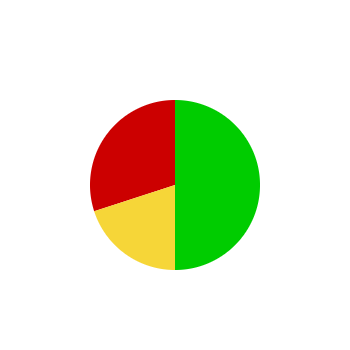

In [281]:
# Save plot to proper location
folder = 'Visualization' # put all in folder: visualization
plotType = '-fa'          # type: fresh air
# week number and home alias from earlier variables
directory = dir_name + "/" + folder + "/"

# If directory path does not exist - create it
if not path.exists(directory):
    makedirs(directory)

fullPathToPlot = directory + str(alias + plotType + ".png")
    
val = [50, 20, 30]
# Plot of air 
fig = {
    'data': [{'labels': ['Indenfor anbefaling', 'Lidt over anbefaling', 'Over anbefaling'],
              'values': val,
              'type': 'pie',
              'marker': {'colors': [pieGreen,
                                    pieOrange,
                                    pieRed]},
              'textinfo': 'none'}],              
    'layout': { 'autosize': False,
                'width': 350,
                'height': 350,
                "paper_bgcolor": "rgba(0, 0, 0, 0)",
                "plot_bgcolor": "rgba(0, 0, 0, 0)",
                'showlegend': False}
     }

# Save to folder
py.image.save_as(fig, filename=fullPathToPlot)
Image(fullPathToPlot) # Display static image
# Plot result
#py.iplot(fig)

In [165]:
fullPathToPlot

'Week_11/Visualization/testhr.png'

----
## <span style="color:darkred">Netatmo arbejde</span> 

### Find alle Netatmo filer

In [14]:
# Find all files in folder
# Keep all files with extension .xls (the Netatmo files)
netatmo_files = []
netatmo_files += [file for file in listdir('.') if file.endswith('.xls')]
# Print list of files
print "Files:\n", netatmo_files, "\n\nNumber of files: %d" % len(netatmo_files)

Files:
['K\xf8kken_3_3_2017.xls', 'Sovev\xe6relse_3_3_2017.xls', 'Stue_3_3_2017.xls'] 

Number of files: 3


### Read Netatmo files

#### Extract overall temperature for all homes - per room file

In [15]:
# files for room data
all_time_liv = pd.DataFrame()
all_time_bed = pd.DataFrame()

liv_pattern = (re.compile(livingroom_pattern))
bed_pattern = (re.compile(bedroom_pattern))

# Merge all files for given room (living room (+ kitchen/upstairs), bedroom)
for room_file in netatmo_files:
    if liv_pattern.match(room_file):
        # read file
        liv_data = pd.read_excel(room_file) 
        # Change range of data and give new column names
        liv_data.columns = liv_data.iloc[1,:]
        liv_data = liv_data.drop(liv_data.index[[0,1]])
        
        # Add content to all time data file
        all_time_liv.append([liv_data])
        
    elif bed_pattern.match(room_file):
        # read file
        bed_data = pd.read_excel(room_file) 
        # Change range of data and give new column names
        bed_data.columns = bed_data.iloc[1,:]
        bed_data = bed_data.drop(bed_data.index[[0,1]])
        
        # Add content to all time data file
        all_time_bed.append([bed_data])
        
    else: 
         print "Error! File: %s missing room classification!" % room_file

Error! File: K�kken_3_3_2017.xls missing room classification!


In [314]:
new = liv_data.groupby([liv_data["Timezone : Europe/Stockholm"].dt.day, liv_data["Timezone : Europe/Stockholm"].dt.hour]).mean()

In [16]:
liv_data['Timezone : Europe/Stockholm'] = pd.to_datetime(liv_data['Timezone : Europe/Stockholm'])
# Append our to existing dataframe
liv_data['Hour'] = liv_data['Timezone : Europe/Stockholm'].dt.hour

runMean = []
# Create full list
for day in liv_data['Timezone : Europe/Stockholm'].dt.day:
    days = liv_data.loc[liv_data['Timezone : Europe/Stockholm'].dt.hour.isin([day])]
    runMean.append(days['Temperature'].sum(axis=0)/len(days['Temperature'])) # selects columns


ZeroDivisionError: integer division or modulo by zero

In [17]:
len(liv_data)
#liv_data['Timezone : Europe/Stockholm'].dt.day

1997

In [237]:
#test 
import re
pattern = re.compile(livingroom_pattern)
if pattern.match('kken_luvet'):
    print 'yes!'

yes!


#### Read data per home

In [25]:
# Indlæs netatmo data -- this will need to extract data based on home
for room_file in netatmo_files:
    netatmo_data = pd.read_excel(room_file) 
    # Get name for output file
    location_name = netatmo_data.iloc[0,0]

    # Get room for output file
    room_name = netatmo_data.iloc[0,3]
    
    # Change range of data and give new column names
    netatmo_data.columns = netatmo_data.iloc[1,:]
    netatmo_data = netatmo_data.drop(netatmo_data.index[[0,1]])
    
    # Make TimeSearies from Timestamp
    netatmo_data["Timezone : Europe/Stockholm"] = pd.to_datetime(netatmo_data["Timezone : Europe/Stockholm"] )
    # Print sheet values
    print "File:         ", room_file
    print "Location name:", location_name + ",", room_name
    print "Max temp      ", max(netatmo_data.Temperature), "\nMin temp      ", min(netatmo_data.Temperature), "\n"

File:          K�kken_3_3_2017.xls
Location name: He171, Køkken
Max temp       22.8 
Min temp       20.9 

File:          Sovev�relse_3_3_2017.xls
Location name: He171, Soveværelse
Max temp       22.2 
Min temp       18.2 

File:          Stue_3_3_2017.xls
Location name: He171, Stue
Max temp       22.3 
Min temp       19.8 



#### Extract CO2 - separate files

In [64]:
# CO2
# for each location
# up to 1000     - greeen
# 1000-1500      - gul
# 1500 and above - red
co2_1000 = netatmo_data.loc[netatmo_data['CO2'] < 1000]
co2_1500 = co2_1000.loc[co2_1000['CO2'] > 1500]       
co2_2000 = co2_1500.loc[co2_1500['CO2'] > 2000] 
# Need more info -- should the data be between 1000 and 1500, 1500 and 2000 and all above?

# Should only run on data within present times..

#### Function: Extract humidity data
Remember to remove last columns from have data!

In [ ]:
# Functions for extracting data
def calculateHourlyTemp(dataFrame, hourName, tempName):
    hour_cnt = {}
    for hour in list(set(dataFrame[hourName])):
        hourly = dataFrame.loc[dataFrame[hourName].isin([hour])]
        hour_cnt[hour] = hourly[tempName].sum(axis=0)/(len(hourly))
    return hour_cnt

### Extract ``have`` file information -- outdoor temperature

In [247]:
# Read netatmo outdoor temp
have_fil = pd.read_excel('have_3_4_2017.xls',sheetname='Worksheet')

# Clean-up: remove header and first 2 rows
have_fil.columns = have_fil.iloc[1,:]
have_fil = have_fil.drop(have_fil.index[[0,1]])

# Add hour label
have_fil['HOUR']     = pd.to_datetime(have_fil['Timezone : Europe/Copenhagen']).dt.hour
netatmo_data['HOUR'] = pd.to_datetime(netatmo_data['Timezone : Europe/Stockholm']).dt.hour

# Create hourly vectors for t_i and t_u
hour_cnt_netatmo = calculateHourlyTemp(netatmo_data, 'HOUR', 'Temperature')
hour_cnt_have    = calculateHourlyTemp(have_fil, 'HOUR', 'Temperature')

# initialize arrays for limit values rh_gul and rh_roed
rh_gul = []
rh_roed = []

# Calculations for humidity equation
# Constants
for i in range(0,24):
    calc = netatmo_data.loc[netatmo_data['HOUR'].isin([i])]
    t_i     = np.asarray(hour_cnt_netatmo.values())
    t_ude   = np.asarray(hour_cnt_have.values())
    
    t_v     = np.add(Fraction(1,3)*t_ude[i], Fraction(2,3)*t_i[i])

    # Limit equations
    p_mv = (math.exp(77.3450 + 0.0057*t_v) - (7235.0 / t_v) / t_v**8.2)
    p_mi = (math.exp(77.3450 + 0.0057*t_i[i]) - (7235.0 / t_i)[i] / t_i[i]**8.2)

    # Equation for upper and lower bound
    rh_gul.append(100*0.6*p_mv/p_mi)
    rh_roed.append(100*0.75*p_mv/p_mi)

#### Calculate humidity as fraction of time within the tree boundaries, plot result
Save the result to Visualization folder

He171 Stue


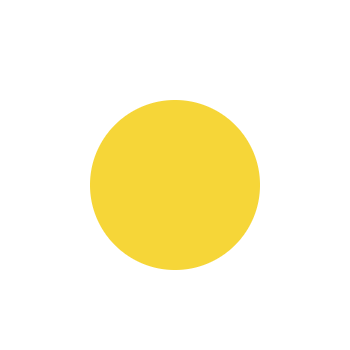

In [267]:
# Humidity
# Missing outdoor temp
# Only for rooms with humidity measure
hr_data    = netatmo_data[['Humidity', 'Temperature', 'HOUR']]
rh_dict = dict.fromkeys(['middleValue', 'lowValue', 'highValue'], 0)

# Check netatmo data against humidity boundaries for each hour of day
for i in range(0, len(hr_data['Humidity'])):
    
    # if humidity value are between rh_gul and rh_roed 
    if hr_data.iloc[i,0] > rh_gul[hr_data.iloc[i,2]] and hr_data.iloc[i,0] < rh_roed[hr_data.iloc[i,2]]:
        rh_dict['middleValue'] += 1
    # If humidity is less than rh_gul
    elif hr_data.iloc[i,0] < rh_gul[hr_data.iloc[i,2]]:
        rh_dict['lowValue'] += 1
    # If humidity is greater than rh_roed 
    elif hr_data.iloc[i,0] > rh_roed[hr_data.iloc[i,2]]:
        rh_dict['highValue'] += 1
    else:
        print 'Something fails'
        
# percentages for plotting
print location_name, room_name


# Save plot to proper location
folder = 'Visualization'  # put all in folder: visualization
plotType = '-hr'           # type: humidity rate
# week number and home alias from earlier variables
directory = dir_name + "/" + folder + "/"

# If directory path does not exist - create it
if not path.exists(directory):
    makedirs(directory)

fullPathToPlot = directory + str(location_name + room_name + plotType + ".png")
    
# Plot over fresh air 
fig = {
    'data': [{'labels': ['Under anbefaling', 'Indenfor anbefaling', 'Over anbefaling'],
              'values': [rh_dict['lowValue']   / len(hr_data)*100,
                         rh_dict['middleValue']/ len(hr_data)*100,
                         rh_dict['highValue']  / len(hr_data)*100],
              'type': 'pie', 
              'marker': {'colors': [pieOrange,
                                    pieGreen,
                                    pieRed]},
              'textinfo': 'none', 
              'showlegend': False,
              "paper_bgcolor": "rgba(0, 0, 0, 0)",
              "plot_bgcolor": "rgba(0, 0, 0, 0)"}],
    'layout': { 'autosize': False,
                'width': 350,
                'height': 350,
                "paper_bgcolor": "rgba(0, 0, 0, 0)",
                "plot_bgcolor": "rgba(0, 0, 0, 0)",
                'showlegend': False}
     }

# Save to folder
py.image.save_as(fig, filename=fullPathToPlot)
# Plot result
Image(fullPathToPlot) # Display a static image
#py.iplot(fig)

### Temperature plot

In [ ]:
# Avg temp for all homes
# When full dataset is present

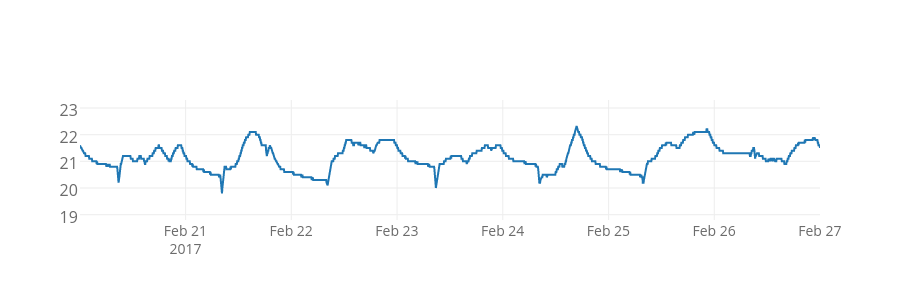

In [274]:
# Save plot to proper location
folder         = 'Visualization' # put all in folder: visualization
plotType       = '-temp'          # type: temperature
# Week number and home alias from earlier variables
directory = dir_name + "/" + folder + "/"

# If directory path does not exist - create it
if not path.exists(directory):
    makedirs(directory)

fullPathToPlot = directory + str(alias + plotType + ".png")

# Plotting weekly temperature overview
# Users comsumption
trace1 = go.Scatter(
          x = pd.to_datetime(netatmo_data["Timezone : Europe/Stockholm"]),
          y = list(netatmo_data.Temperature),
    name = 'Din bolig', # Style name/legend entry with html tags
    connectgaps=False
)

# Overall consumption mean for hedelyngen
# To create mean of all homes -- read in full file and calculate mean per hour per day of week, data from what?
"""trace2 = go.Scatter(
    x=[1, 2, 3, 4, 5,
       6, 7, 8, 9, 10,
       11, 12, 13, 14, 15],
    y=[5, 15, None, 10, 5,
       0, 10, None, 15, 5,
       5, 10, 20, 15, 5],
    name = 'Hedelyngen',
)"""

data = [trace1]

# Setting layout details for plot
layout = go.Layout(
    autosize = False,
    width = 900,
    height = 300,
    paper_bgcolor = 'rgba(0, 0, 0, 0)',
    plot_bgcolor = "rgba(0, 0, 0, 0)",
    showlegend = False,

    xaxis=dict(
        tickfont=dict(
            size=14,
            color=ticksAxes
        )
    ),
    
    yaxis=dict(
        range=[min(list(netatmo_data.Temperature))-1,max(list(netatmo_data.Temperature))+1],
        zeroline=True,
        titlefont=dict(
            size=16,
            color=ticksAxes
        ),
        tickfont=dict(
            size=16,
            color=ticksAxes
        )
    ),
    
    legend=dict(
        x=0,
        y=1.0,
        bgcolor=bgBorder,
        bordercolor=bgBorder
    )
)

fig = go.Figure(data=data, layout=layout)
py.image.save_as(fig, filename=fullPathToPlot)
Image(fullPathToPlot) # Display a static image

### Heat consumption plot

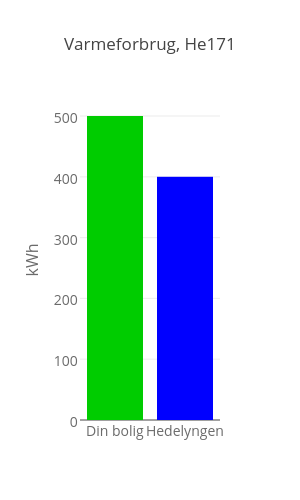

In [275]:
# Save plot to proper location
folder = 'Visualization'  # put all in folder: visualization
plotType = '-hc'           # type: heat consumption
# week number and home alias from earlier variables
fullPathToPlot = dir_name + "/" + folder + "/" + alias + plotType + ".png"

# Plot of heat consumption, your home vs. all 
data = [go.Bar(
            x=['Din bolig', 'Hedelyngen'],
            y=[500, 400],
            marker=dict(
                  color= [homeGreen,hedeBlue]
        )
    )]

layout = go.Layout(
    title='Varmeforbrug, ' + location_name,
    autosize=False,
    width=300,
    height=500,
    paper_bgcolor = 'rgba(0, 0, 0, 0)',
    plot_bgcolor = "rgba(0, 0, 0, 0)",
    showlegend = False,
    xaxis=dict(
        tickfont=dict(
            size=14,
            color=ticksAxes
        )
    ),
    yaxis=dict(
        title='kWh',
        titlefont=dict(
            size=16,
            color=ticksAxes
        ),
        tickfont=dict(
            size=14,
            color=ticksAxes
        )
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor=bgBorder,
        bordercolor=bgBorder
    )
)

fig = go.Figure(data=data, layout=layout)
# Save static image
py.image.save_as(fig, filename=fullPathToPlot)
Image(fullPathToPlot) # Display a static image

#py.iplot(fig, filename='style-bar')

### CO2 plot

### Humidity plot

## <span style="color:darkred">Accessing Netatmo from their API</span>
* [API description on GitHub](https://github.com/philippelt/netatmo-api-python)

In [116]:
import lnetatmo

In [176]:
# 'indeklima.forsog@gmail.com'